# HGCAL FE studies

### imports and initial setup

In [3]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal

from time import sleep
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly as py

from descartes import PolygonPatch
from tqdm import tqdm_notebook

import scripts.helpers as hlp
from skhep.modeling import bayesian_blocks

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 16})

#%connect_info

/home/naodell/work/hgcal


### Convert data from root ntuples to dataframes

In [4]:
#infile = open('data/mc_mixtures/qcd_pt15to7000_skim_test/output_0.pkl', 'rb')
#infile = open('data/mc_mixtures/single_electron_pt15_pu200_skim_test/output_0.pkl', 'rb')
infile = open('data/mc_mixtures/single_pi_pt25_skim_test/output_0.pkl', 'rb')
threshold = pickle.load(infile)
gen = pickle.load(infile)
data = pickle.load(infile)

features = ['zside', 'layer', 'sector', 'panel', 'cell', 'subdet',
            'x', 'y', 'z', 
            'pt', 'reco_e', 'sim_e']


### Visualizations of detector hits, panels, and occupancies

In [ ]:
# find event with gen electron passing through sector 1 on the +z side
layer = 7
sector = 1
panel = 4

ievt = 18
dphi_min = np.pi
for i, part in enumerate(gen):
    e1 = part.iloc[0]
    e2 = part.iloc[1]
    
    dphi = abs(e1.phi - np.pi) if e1.phi > 0 else abs(np.pi + e1.phi)
    #print(i, e1.phi, dphi)
    if dphi < dphi_min:
        ievt = i
        dphi_min = dphi
       

IndexError: single positional indexer is out-of-bounds

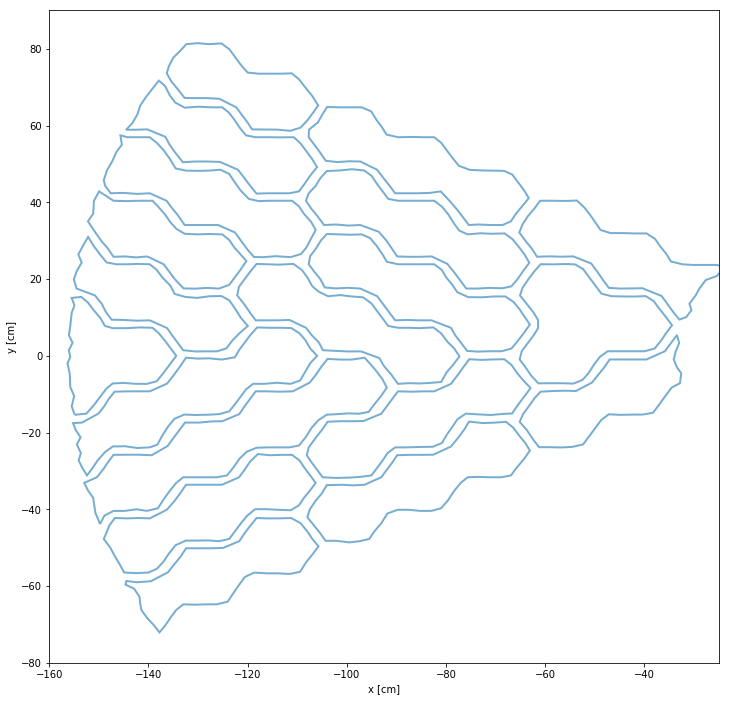

In [6]:
# get event and plot it 
df = data[ievt].query('sig_evt')[features]
patch_file = open(f'data/panel_patches_zplus_{layer}.pkl', 'rb')
patches = pickle.load(patch_file)
patch_file.close()

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')
for p, ashape in patches[sector].items():
    col = 'C0'
    patch = PolygonPatch(ashape, fill=False, ec=col, linestyle='-', linewidth=2, label='_nolegend_', alpha=0.6)
    ax.add_patch(patch)

df_skim = df.query(f'subdet == 3 and zside == 1 and sector == {sector} and layer == {layer}')
mask = df_skim.sim_e > 0

sim_scat  = ax.scatter(df_skim[mask].x, df_skim[mask].y, c=df_skim.sim_e[mask], 
                       cmap='viridis', 
                       marker='*', 
                       vmin=0.,
                       vmax=2.,
                       s=85, 
                       alpha=1.
                      )
reco_scat = ax.scatter(df_skim.x, df_skim.y, c=df_skim.reco_e, 
                       cmap='viridis', 
                       marker='h', 
                       vmin=0.,
                       vmax=2.,
                       s=50, 
                       alpha=0.45
                      )

ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

cbar_reco = plt.colorbar(reco_scat, ax=ax, label='E [GeV]')
cbar_reco.set_alpha(1)
cbar_reco.draw_all()

#cbar_sim = plt.colorbar(sim_scat, ax=ax, label=r'$E_{sim}$')
plt.legend(['simhit', 'recohit'])
plt.grid()

plt.savefig('plots/hits_test.png')
plt.show()